# Homework 5

## REST
First step is to fetch the data. With the package `httr2`, we can initialize a request object using `request()`, specifying the URL and then send the request to the server using `req_perform()`.

In [1]:
library(httr2)

# Define the URL for the API
url <- "https://api.nobelprize.org/2/nobelPrizes?nobelPrizeCategory=phy&format=json"

# Create a request object
request_obj <- request(url)

# Perform the request and fetch the data
response <- request_obj %>%
  req_perform()

The API response is in JSON format and R cannot use this directly. This is where we use the package `jsonlite` to parse the response body, using `resp_body_json()`, which converts the JSON response into an R object.

In [2]:
library(jsonlite)

# Parse the response body into a JSON object
data <- response %>%
    resp_body_json(flatten = TRUE)

The next step is to extract all the prize motivations from the parsed JSON. After checking the structure of our parsed JSON, `laureates` list is nested under each item in `data$nobelPrizes`and each `motivation$en` is within individual laureates. 

To achieve this, we can use the function `lapply()` to loop through all Nobel Prizes and `sapply()` to loop through each laureate within a prize to extract their motivation. After, we use `unlist()` to convert the list of motivations into a simple character vector.

In [3]:
# Extract the motivations from all prizes
motivations <- unlist(
  lapply(data$nobelPrizes, function(prize) {
    if (!is.null(prize$laureates)) { # Check if there are laureates
      sapply(prize$laureates, function(laureate) laureate$motivation$en)
    }
  })
)

Next, we want to prepare the motivations for visualization. That is; converting all text to lowercase, removing punctuation, numbers and common stopwords, stripping extra whitespace. 

This can be done by using the package `tm`.

In [4]:
library(tm)

# Create a text corpus from the motivations
corpus <- Corpus(VectorSource(motivations))

# Preprocess the text
corpus_clean <- tm_map(corpus, content_transformer(tolower))       # Convert to lowercase
corpus_clean <- tm_map(corpus_clean, removePunctuation)            # Remove punctuation
corpus_clean <- tm_map(corpus_clean, removeNumbers)                # Remove numbers
corpus_clean <- tm_map(corpus_clean, removeWords, stopwords("en")) # Remove common stopwords
corpus_clean <- tm_map(corpus_clean, stripWhitespace)              # Remove extra spaces

# Convert back to a character vector
cleaned_motivations <- sapply(corpus_clean, as.character)

Loading required package: NLP

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus_clean, removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus_clean, removeNumbers):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus_clean, removeWords, stopwords("en")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus_clean, stripWhitespace):
"transformation drops documents"


Finally, we visualize the word frequencies using the package `wordcloud` to generate a word cloud.

Loading required package: RColorBrewer

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"


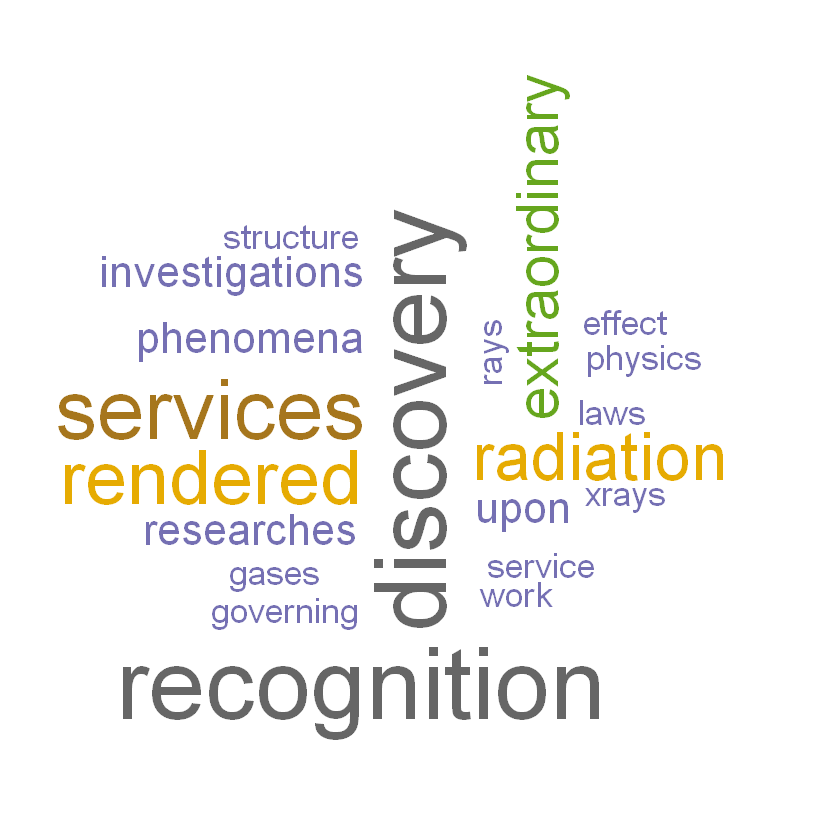

In [5]:
library(wordcloud)
library(RColorBrewer) # Used to select a preferable color palette

# Generate the word cloud
wordcloud(words = cleaned_motivations,
         scale = c(5, 0.5),
         max.words = 100,
         random.order = FALSE,
         colors = brewer.pal(8, "Dark2"))

From the word cloud, we see that **discovery** and **recognition** are the most frequent words for prize motivations.

## Web Scraping
We start by loading necessary libraries

In [6]:
library(rvest)
library(tidyverse)

-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x ggplot2::annotate()     masks NLP::annotate()
x dplyr::filter()         masks stats::filter()
x purrr::flatten()        masks jsonlite::flatten()
x readr::guess_encoding() masks rvest::guess_encoding()
x dplyr::lag()            masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next step is to explore the website's structure by inspecting the webpage. Key observations are:

- URLs for pages: `https://books.toscrape.com/catalogue/page-x.html`, where `x` represents the page (e.g. `page-2.html` yields the second page)
- Each book links to a detail page, where:
    - UPC is a row `<tr>` in a HTML table found under `<tbody>`
    - Title is in an `<h1>` tag
    - Price is in `<p class="price_color">`
    - Rating is a class in `<p class="star-rating">` but is encoded as part of the `class` attribute.

Now we can write a function to scrape the desired book details.

In [7]:
scrape_book_details <- function(book_url) {
    # Read the book HTML and init a list to store book details
    html <- read_html(book_url)
    book_details <- list()

    # Extract UPC from the table by looping through each row (<tr>)
    table <- html %>% html_element("table")
    rows <- table %>% html_elements("tr")
    for (row in rows) {
        th <- row %>% html_element("th") %>% html_text2()
        td <- row %>% html_element("td") %>% html_text2()
        if (th == "UPC") {
            book_details$upc <- td
        }
    }

    # Extract the books title, price and rating
    book_details$title <- html %>% html_element("h1") %>% html_text2()
    book_details$price <- html %>% html_element(".price_color") %>% html_text2()
    star_rating <- html %>% html_element(".star-rating") %>% html_attr("class")
    book_details$rating <- gsub("star-rating ", "", star_rating)

    as.data.frame(book_details, stringAsFactors = FALSE)
}

Next step is to extract links to all books listed on a page and apply `scrape_book_details` function to each of those links.

Upon further inspection we find that these links are located in a hyperlink `<a>` within the the `<h3>` tags of each book, under `class=product_pod`.

In [8]:
scrape_page <- function(page_url) {
    # Read the page HTML
    html <- read_html(page_url)

    # Extract book links
    book_links <- html %>%
        html_elements(".product_pod h3 a") %>%
        html_attr("href")

    base_url <- "https://books.toscrape.com/catalogue/"
    book_links <- paste0(base_url, str_replace(book_links, "^\\.\\./\\.\\./", ""))
    
    # Scrape details for each book and then return
    book_details <- map_dfr(book_links, scrape_book_details)

    return(book_details)
}

We are now ready to scrape all books from the first three pages.

In [9]:
# Define the URLS for page 1, 2 and 3
base_url <- "https://books.toscrape.com/catalogue/page-"
page_urls <- paste0(base_url, 1:3, ".html")

# Scrape all pages and combine the results
books <- map_dfr(page_urls, scrape_page)
books

upc,title,price,rating
<chr>,<chr>,<chr>,<chr>
a897fe39b1053632,A Light in the Attic,£51.77,Three
90fa61229261140a,Tipping the Velvet,£53.74,One
6957f44c3847a760,Soumission,£50.10,One
e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
f77dbf2323deb740,The Requiem Red,£22.65,One
2597b5a345f45e1b,The Dirty Little Secrets of Getting Your Dream Job,£33.34,Four
e72a5dfc7e9267b2,"The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull",£17.93,Three
e10e1e165dc8be4a,The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics,£22.60,Four
